### Load output of TSM

In [423]:
import pandas as pd
df = pd.read_pickle(r"/rwthfs/rz/cluster/work/vt572371/Thesis-emotion-detection/TimeSformer/output/runs/cremad-nopretrain/output_cremad.pkl")
arr1 = df[0].numpy()
arr2 = df[1].numpy()

In [424]:
print(arr1.shape)
print(arr2.shape)

(1116, 6)
(1116,)


### Load output of Transformer

In [414]:
import json
import numpy as np
with (open("work_dirs/affwild/output.json", "rb")) as f:
    data = np.asarray(json.load(f))
    

In [415]:
data.shape

(918, 7)

## Multiclass ROC function, takes output array, input label array, number of classes and model name

In [420]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt


def multiclass_roc(y_preds,y_labels,n_classes,model):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_labels)
    classes = lb.classes_
    labels = preprocessing.label_binarize(y_labels,classes)
    
    y_preds_int = y_preds.astype(int)
   
   
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels[:,i],y_preds[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
   
    conf_mat = confusion_matrix(y_preds.argmax(axis=1), labels.argmax(axis=1))
    f1 = f1_score(y_preds.argmax(axis=1), labels.argmax(axis=1),average='weighted')
    acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
    c_score = 0.67*f1+0.33*acc
    

    print(f'accuracy:{acc} and f1score: {f1} and challenge score:{c_score}')
        
    

    
    fpr["micro"], tpr["micro"], _ = roc_curve(labels.ravel(), y_preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr +=interp(all_fpr,fpr[i],tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
    plt.figure(figsize=(7,7),dpi=100)
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','firebrick','navy','burlywood','forestgreen'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic of Affwild Dataset on {model}')
    plt.legend(loc="lower right")
    plt.show()
    
    


/home/vt572371/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
<ipython-input-420-30bbefaa1f3f>:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr +=interp(all_fpr,fpr[i],tpr[i])


accuracy:0.7186379928315412 and f1score: 0.7255304970644814 and challenge score:0.7232559706676112


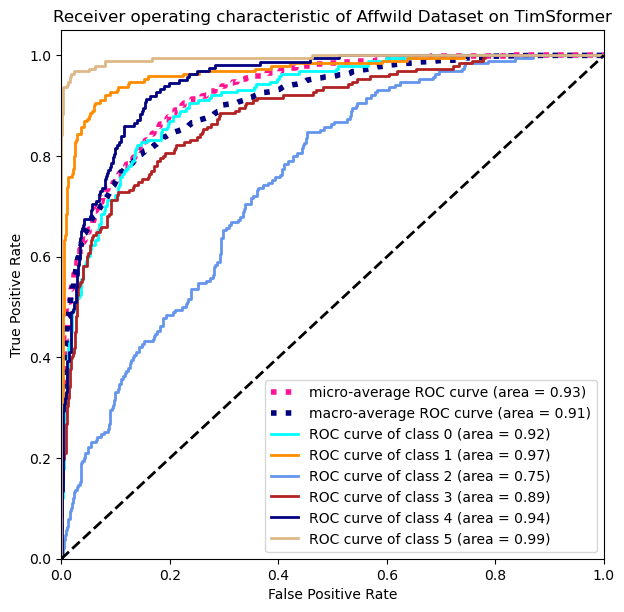

In [426]:
multiclass_roc(arr1,arr2,6,'TimSformer')